
# Gráficos

Metamos los gráficos que necesitamos en esta notebook

In [1]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import contrastes
import seaborn as sns
import pymongo 

database_name = "contrastes"
client = pymongo.MongoClient('localhost', 27017)
db = client[database_name]

collection = db.tweets



In [2]:
users = collection.distinct("user_id")

len(users)

56308

In [3]:
counts = np.array([collection.find({"user_id": user_id}).count() for user_id in users])
    

In [4]:
%%time
from nltk.tokenize import TweetTokenizer
import multiprocessing

tokenizer = TweetTokenizer(
    preserve_case=False,
    reduce_len=True,
)

processing_batch = 200000
tweet_iter = db.tweets.find().batch_size(processing_batch).limit(int(1e7))

len_counts = []

def get_len_tokens(text):
    return len(tokenizer.tokenize(text))

try:
    while True:
        next_tweets = [next(tweet_iter)['text'] for _ in range(processing_batch)]
        with multiprocessing.Pool(4, maxtasksperchild=200) as pool:
            new_counts = pool.map(get_len_tokens, next_tweets)
            len_counts = np.concatenate((len_counts,new_counts))
except StopIteration:
    print("Terminamos => {}M tweets tokenizados".format(len(len_counts) / 1e6))

Terminamos => 10.0M tweets tokenizados
CPU times: user 1min 49s, sys: 6.39 s, total: 1min 55s
Wall time: 8min 43s


In [7]:
len(counts)

56308

In [12]:
counts = np.array(counts)

Text(0,0.5,'Frequency')

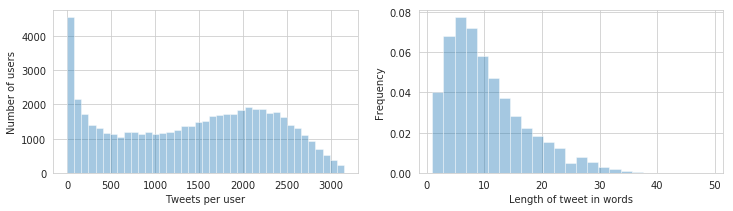

In [40]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
g = sns.distplot(counts[counts < 3150], norm_hist=False, kde=False)
g.grid(True)

g.set_xlabel("Tweets per user")
g.set_ylabel("Number of users")

plt.subplot(1, 2, 2)

lens = len_counts[len_counts < 50]
g = sns.distplot(lens, norm_hist=True, kde=False, bins=25)

g.grid(True)

g.set_xlabel("Length of tweet in words")
g.set_ylabel("Frequency")

In [41]:
fig.savefig("../output/figures/dataset_histograms.png", bbox_inches='tight')